In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'


In [2]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

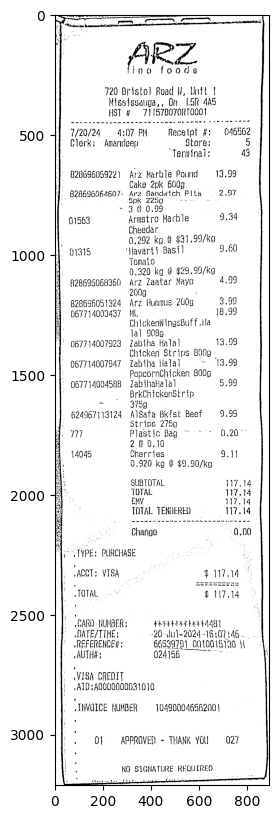

In [3]:
file_name = "result_4.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)

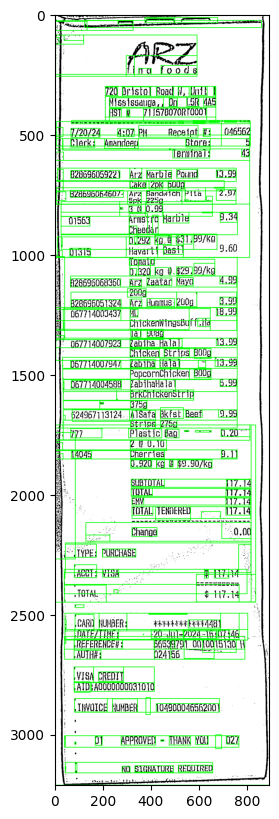

In [4]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [5]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

Ca

nes a

RS eo
rf no foods

720 Bristol Road Wy Unit 1
Mississauga,, On. [OR 4A5
HST # TIIS7B070RT0001

ee ee mh OE me Fe ee we

1) 7/20/24 4:07 PH_—sRecetot: Hs nse

~ Clerk: Amandeep __ Store:
ay Terminal: 43
J: 828696059221 Arg Marble Pound 13.99
an Cake 2pk 600q a
a. 828696064607- Anz Sepautch. P Pita : (2.97

~ 3.8 0.99 a

01563 brnst 9 Harble 3,34

rn

; 292 kg.@ $31. 95/ka

1, 01315 ‘fever Basi]

Tomato

0, 320 kg @ $29. 99/kg

26696060360 Arz Zaatar Mayo 4.99

200g

828698051924 Arz Hummus 2000. 3.99

067714003437 ML 18.99
; thiickent/ingsbu tl

at Ja]: 9g

“067714007923 Zabiha-Halal: 43.99
Chicken Strips 800g

: 067714007947 Zabiha Halal =~ «13.98

FopeornChicken 800g

» 067714004588 Zabihatala] 5.99

_ BrkChickenStrip

~ 375g

- 624967113124... AlSafa Bkfst Beef 9.99

( Strips 2759

moe

di 777° Plasto Bag ~ > 0.20"
4 260,10
|. 14045 Cherries 9.4]
0.920 kg @ $9.90/k9
SUBTOTAL 117.14
TOTAL 17.14
EMV 117.14
TOTAL TENDERED =| 117.14
cee Change “9,00
SAYPE: PURCHASE 4
— TACCT: 

In [6]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    unique = list(dict.fromkeys(floats))
    return unique
amounts = find_amounts(extracted_text)
amounts

[13.99,
 2.97,
 0.99,
 4.99,
 3.99,
 18.99,
 43.99,
 13.98,
 5.99,
 9.99,
 0.2,
 9.9,
 117.14,
 17.14]

In [9]:
from transformers import LlamaTokenizer, LlamaForCausalLM
import torch
import re

# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Llama model and tokenizer
model_name = "openlm-research/open_llama_3b"
tokenizer = LlamaTokenizer.from_pretrained(model_name)
model = LlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16).to(device)

def generate_concise_name(description):
    prompt = f"Summarize this product description into a short, concise name: {description}\nConcise name:"
    inputs = tokenizer(prompt, return_tensors="pt").to(device)  # Ensure inputs are on the correct device
    
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=10, num_return_sequences=1)
    
    # Decode and extract the concise name from the output
    concise_name = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    
    # Handle the possibility of the output containing the "Concise name:" phrase
    if "Concise name:" in concise_name:
        concise_name = concise_name.split("Concise name:")[-1].strip()
    
    return concise_name

def clean_and_summarize_products(extracted_text):
    lines = extracted_text.split('\n')
    products = []
    
    # Refine regex: Exclude lines that are likely IDs (long numbers)
    for line in lines:
        # Skip lines that are mostly numeric or very short, likely not product names
        if re.match(r'^\d{7,}$', line.strip()) or len(line.strip()) < 5:
            continue
        
        # Basic pattern to match product descriptions followed by a price
        match = re.match(r'(.+?)\s+(\d+\.\d{2})$', line)
        if match:
            description, price = match.groups()
            concise_name = generate_concise_name(description)
            
            # Avoid adding entries that are clearly incorrect or too generic
            if not re.match(r'^\d{7,}$', concise_name) and "Summarize" not in concise_name:
                products.append((concise_name, float(price)))
    
    return products


concise_products = clean_and_summarize_products(extracted_text)
print(concise_products)



Using device: cuda
[('J: 8286960', 13.99), ('“067714007', 43.99), ('Zabihatala\nZabihatala', 5.99), ('- 62496711', 9.99), ('EMV\nEMV is a standard for smart', 117.14), ('TOTAL TENDERED\nSummar', 117.14)]
